Reference: https://github.com/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb

In [1]:
import os
import numpy
import keras
import random
import zipfile
import tempfile
import requests
import tensorflow
import matplotlib.pyplot as pyplot
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import History
from matplotlib.figure import Figure, Axes
from numpy import ndarray, dtype
from typing import Any
from PIL.ImageFile import ImageFile
from PIL import UnidentifiedImageError

Define some helper functions:

In [2]:
def download_dataset(zip_url: str, destination_path: str) -> str:
    """
    Downloads a zip file and extracts it to the specified directory.
    :param zip_url: The URL to the zip file.
    :param destination_path: The directory the contents of the zip file should be extracted to.
    :return: The absolute path to the directory with the contents of the zip file.
    """
    absolute_destination_path: str = os.path.abspath(destination_path)

    # Create the destination directory if it doesn't exist
    os.makedirs(absolute_destination_path, exist_ok=True)

    # Download the zip file to a temporary file in the system's temp directory
    with requests.get(zip_url, stream=True) as response:
        response.raise_for_status()  # Check for HTTP request errors

        # Create a named temporary file with .zip suffix
        with tempfile.NamedTemporaryFile(suffix='.zip', delete=False) as temp_file:
            zip_file_path: str = temp_file.name

            # Download the zip file in chunks
            for data_chunk in response.iter_content(chunk_size=8192):
                if data_chunk is not None:
                    temp_file.write(data_chunk)

    # Extract the zip file to the destination directory
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(absolute_destination_path)

    # Delete the temporary zip file
    os.remove(zip_file_path)

    return absolute_destination_path


def is_directory_empty(directory_path: str) -> bool:
    """
    Checks if the specified directory is empty.
    :param directory_path: The absolute path to the directory.
    :return: True if the directory is empty or does not exist, False otherwise.
    """
    return not os.path.exists(directory_path) or len(os.listdir(directory_path)) == 0


def process_image(image_path: str, target_height: int, target_width: int) -> tuple[ImageFile | None, ndarray[tuple, dtype]]:
    """
    Loads and preprocesses an image.
    :param image_path: The absolute path to the image.
    :param target_height: The desired height for the preprocessed image.
    :param target_width: The desired width for the preprocessed image.
    :return: The image and the input vector.
    """
    try:
        image: ImageFile = keras.preprocessing.image.load_img(image_path, target_size=(target_height, target_width))
        input_vector: ndarray[tuple, dtype] = keras.preprocessing.image.img_to_array(image)
        input_vector = numpy.expand_dims(input_vector, axis=0)
        input_vector = keras.applications.imagenet_utils.preprocess_input(input_vector)
        return image, input_vector
    except UnidentifiedImageError:
        print(f'Failed to process {image_path}')
        return None, numpy.empty((0,), dtype=object)


def get_training_result(history: History, comparison_history: History | None = None) -> Figure:
    """
    Gets all charts with data about the result of a model's training.
    :param history: The raw data of the model's training.
    :param comparison_history: The raw data of another model's training to compare with.
    :return: Charts about the model's training.
    """
    history_chart: Figure = pyplot.figure(figsize=(16,4))

    chart1: Axes = history_chart.add_subplot(121)
    chart1.plot(history.history['val_loss'])
    chart1.set_title('Validation Loss')
    chart1.set_xlabel('Epochs')

    chart2: Axes = history_chart.add_subplot(122)
    chart2.plot(history.history['val_accuracy'])
    chart2.set_title('Validation Accuracy')
    chart2.set_xlabel('Epochs')
    chart2.set_ylim(0, 1)

    if comparison_history is not None:
        chart1.plot(comparison_history.history['val_loss'])
        chart2.plot(comparison_history.history['val_loss'])

    return history_chart


def predict(model: Model, image_path: str) -> ndarray[tuple, dtype]:
    """
    Makes a prediction with the specified neural network model.
    :param model: The neural network model.
    :param image_path: The absolute or relative path the image is located at.
    :return: The model's prediction.
    """
    vectors: ndarray[tuple, dtype] = process_image(image_path, 224, 224)[1]
    return model.predict(vectors)

Download the images, preprocess them and load and them into memory.

In [3]:
zip_url: str = 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
destination_path: str = os.path.abspath('data')
dataset_path: str = os.path.join(download_dataset(zip_url, destination_path) if is_directory_empty(destination_path) else destination_path, 'PetImages')
image_classes: list[str] = os.listdir(dataset_path)

# Load and pre-process all images in memory
samples: list[dict[str, ndarray[tuple, dtype] | int | str]] = []

for index, image_class in enumerate(image_classes):
    for image_name in os.listdir(os.path.join(dataset_path, image_class))[:2000]: # Limit to 2000 images per class due to memory limitations
        image_path: str = os.path.join(dataset_path, image_class, image_name)
        vector = process_image(image_path, 224, 224)[1]
        if (vector.any()):
            samples.append({ 'x': numpy.array(vector[0]), 'y': index, 'img_path': image_path})

print(f'> Loaded {len(samples)} images.')

Failed to process /content/data/PetImages/Cat/Thumbs.db
Failed to process /content/data/PetImages/Dog/Thumbs.db
> Loaded 3998 images.


In [4]:
# Shuffle the sample data
random.shuffle(samples)

# Create training / validation / test splits (70%, 15%, 15%)
train_split: float = 0.7
val_split: float = 0.15

validation_index: int = int(train_split * len(samples))
test_index: int = int((train_split + val_split) * len(samples))

training_set: list[dict[str, ndarray[tuple, dtype] | int]] = samples[:validation_index]
validation_set: list[dict[str, ndarray[tuple, dtype] | int]] = samples[validation_index:test_index]
testing_set: list[dict[str, ndarray[tuple, dtype] | int]] = samples[test_index:]

In [5]:
# Separate data for labels.
x_train: ndarray[Any, dtype[Any]] = numpy.array([sample["x"] for sample in training_set])
y_train: list[int] = [sample["y"] for sample in training_set]
x_val: ndarray[Any, dtype[Any]] = numpy.array([sample["x"] for sample in validation_set])
y_val: list[int] = [sample["y"] for sample in validation_set]
x_test: ndarray[Any, dtype[Any]] = numpy.array([sample["x"] for sample in testing_set])
y_test: list[int] = [sample["y"] for sample in testing_set]

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Convert labels to one-hot vectors
y_train: ndarray[Any, dtype[Any]] = keras.utils.to_categorical(y_train, len(image_classes))
y_val: ndarray[Any, dtype[Any]] = keras.utils.to_categorical(y_val, len(image_classes))
y_test: ndarray[Any, dtype[Any]] = keras.utils.to_categorical(y_test, len(image_classes))

Summarize what we have so far.

Finished loading 3998 images from 2 categories
Training: 2798 | Validation: 600 | Testing: 600
Training data shape:  (2798, 224, 224, 3)
Training labels shape:  (2798, 2)


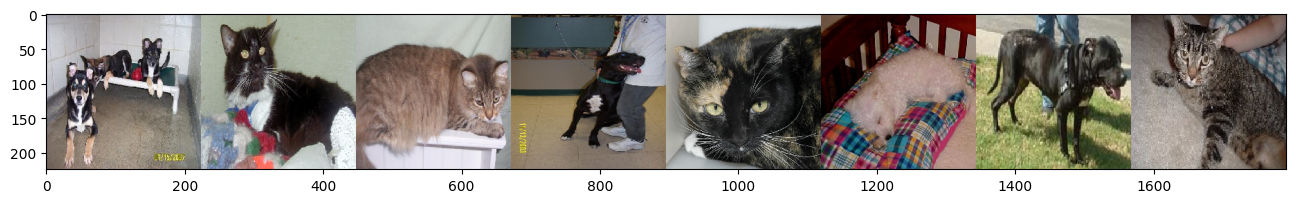

In [6]:
print_images: list[ImageFile] = [process_image(sample['img_path'], 224, 224)[0] for sample in samples[:8]]
concat_image: ndarray[Any, dtype] = numpy.concatenate([numpy.asarray(image) for image in print_images], axis=1)
pyplot.figure(figsize=(16,4))
pyplot.imshow(concat_image)

# Print summary
print(f'Finished loading {len(samples)} images from {len(image_classes)} categories')
print(f'Training: {len(x_train)} | Validation: {len(x_val)} | Testing: {len(x_test)}')
print(f"Training data shape: ", x_train.shape)
print(f"Training labels shape: ", y_train.shape)

Create a neural network from scratch.

In [7]:
# build the network
model: Sequential = Sequential()

print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(len(image_classes)))
model.add(Activation('softmax'))

# Use categorical cross-entropy loss function and adadelta optimizer
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Now train the neural network.

In [8]:
print('Starting training...')
history: History = model.fit(x_train, y_train, batch_size=128, epochs=18, validation_data=(x_val, y_val))

Starting training...
Epoch 1/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 939ms/step - accuracy: 0.5103 - loss: 0.7182 - val_accuracy: 0.5500 - val_loss: 0.6829
Epoch 2/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.5962 - loss: 0.6681 - val_accuracy: 0.6050 - val_loss: 0.6600
Epoch 3/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.6259 - loss: 0.6380 - val_accuracy: 0.6250 - val_loss: 0.6443
Epoch 4/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.6616 - loss: 0.6207 - val_accuracy: 0.6433 - val_loss: 0.6311
Epoch 5/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6536 - loss: 0.6198 - val_accuracy: 0.6633 - val_loss: 0.6192
Epoch 6/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.6877 - loss: 0.5828 - val_accuracy: 0.6633 - val_loss: 0.6050
Epoch 7/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7077 - loss: 0.5708 - val_accuracy: 0.6733 - val_loss: 0.5944
Epoch 8/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.7039 - loss: 0.

Print the training result.

Test loss: 0.6261917352676392
Test accuracy: 0.7566666603088379


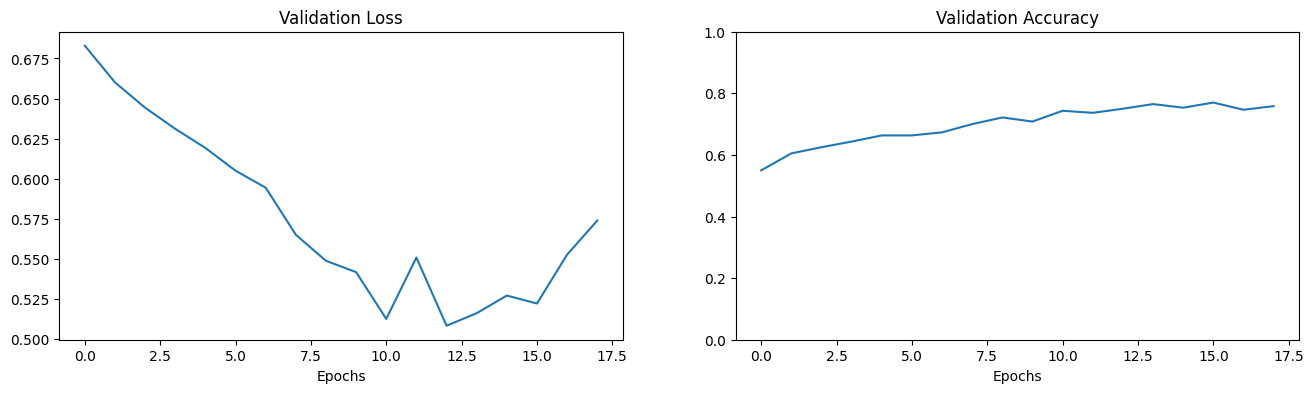

In [9]:
get_training_result(history).show()

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Now let's fine-tune an already existing neural network model.

Start out by downloading the pre-trained model.

In [10]:
# Download the VGG16 model with the 'imagenet' training weights.
vgg: Model = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Create the new model, with all but the last layer frozen so only the last layer gets replaced and retrained.

In [11]:
# VGG's input layer
input_layer: Input = vgg.input

# Make a new softmax layer with len(image_classes) neurons
new_classification_layer: Dense = Dense(len(image_classes), activation='softmax')

# Connect our new layer to the second to last layer in VGG, and grab a reference to it
output_layer: Dense = new_classification_layer(vgg.layers[-2].output)

# Create a new network between input and output
finetuned_model: Model = Model(input_layer, output_layer)

# Freeze all weights, making all layers untrainable (except for the last layer)
for layer in finetuned_model.layers[:-1]:
    layer.trainable = False

# Ensure the last layer is trainable (not frozen)
finetuned_model.layers[-1].trainable = True

finetuned_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

finetuned_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Fine-tune the model.

In [12]:
print('Starting fine-tuning...')
history_finetuned: History = finetuned_model.fit(x_train, y_train, batch_size=128, epochs=18, validation_data=(x_val, y_val))

Starting fine-tuning...
Epoch 1/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.5279 - loss: 0.8860 - val_accuracy: 0.8283 - val_loss: 0.4814
Epoch 2/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 798ms/step - accuracy: 0.8202 - loss: 0.4537 - val_accuracy: 0.8617 - val_loss: 0.3860
Epoch 3/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 684ms/step - accuracy: 0.8406 - loss: 0.3793 - val_accuracy: 0.8667 - val_loss: 0.3371
Epoch 4/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 806ms/step - accuracy: 0.8724 - loss: 0.3189 - val_accuracy: 0.8883 - val_loss: 0.3098
Epoch 5/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 816ms/step - accuracy: 0.8824 - loss: 0.3001 - val_accuracy: 0.8917 - val_loss: 0.2962
Epoch 6/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 814ms/step - accuracy: 0.8882 - loss: 0.2853 - val_accuracy: 0.8983 - val_loss: 0.2791
Epoch 7/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 699ms/step - accuracy: 0.8828 - loss: 0.2837 - val_accuracy: 0.8883 - val_loss: 0.2760
Epoch 8/18
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 813ms/step - accuracy: 0.8815 - l

Print the fine-tuning result.

Test loss: 0.22195599973201752
Test accuracy: 0.9083333611488342


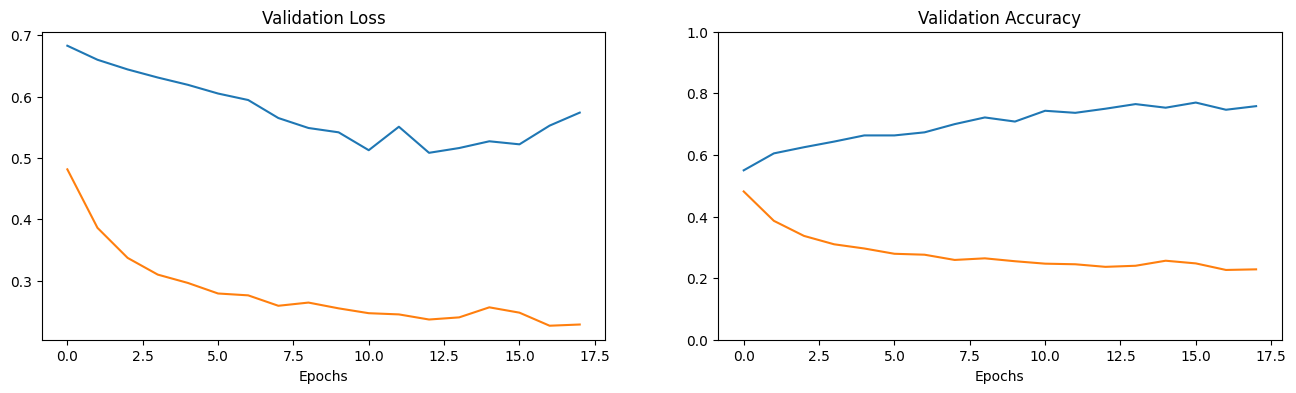

In [13]:
get_training_result(history, history_finetuned).show()

loss, accuracy = finetuned_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Make predictions.

In [14]:
cat_path: str = 'data/PetImages/Cat/0.jpg'
dog_path: str = 'data/PetImages/Dog/0.jpg'

print(f'Cat prediction (old model)       : {predict(model, cat_path)}')
print(f'Cat prediction (fine-tuned model): {predict(finetuned_model, cat_path)}')

print(f'Dog prediction (old model)       : {predict(model, dog_path)}')
print(f'Dog prediction (fine-tuned model): {predict(finetuned_model, dog_path)}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Cat prediction (old model)       : [[2.0916942e-11 1.0000000e+00]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Cat prediction (fine-tuned model): [[0.08253887 0.91746116]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Dog prediction (old model)       : [[0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Dog prediction (fine-tuned model): [[1.5481025e-13 1.0000000e+00]]
